In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [10.0,8.0]
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
%load_ext autoreload
%autoreload 2

In [33]:
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*1/np.tan(t), r*np.tan(t)]
  y[ix] = j

(-1, 1)

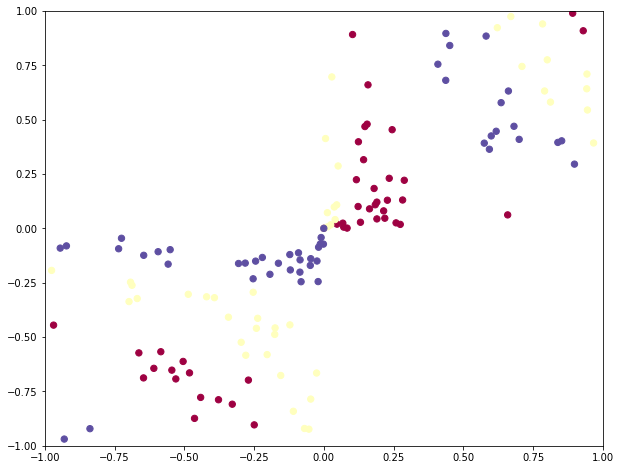

In [58]:
fig = plt.figure()
plt.scatter(X[:,0],X[:,1],c=y,s=40,cmap=plt.cm.Spectral)
plt.xlim(-1,1)
plt.ylim(-1,1)

In [7]:
def sigmoid(x):
    x = 1/(1 + np.exp(-x))
    return x
    
def sigmoid_grad(x):
    return x*(1-x)

def relu(x):
    return np.maximum(0,x)

In [8]:
def three_layer_net(NONLINEARITY,X,y,model,step_size,reg):
    h1= model['h1']
    h2= model['h2']
    W1= model['W1']
    W2 = model['W2']
    W3 = model['W3']
    b1 = model['b1']
    b2 = model['b2']
    b3 = model['b3']
              
    num_examples = X.shape[0]
    plot_array_1 = []
    plot_array_2 = []
    loss_array = []
    loss_mean_array = []
    for i in range(50000):
        
        if NONLINEARITY == 'RELU':
            hidden_layer1 = relu(np.dot(X,W1)+b1)
            hidden_layer2 = relu(np.dot(hidden_layer1,W2)+b2)
            scores = np.dot(hidden_layer2,W3) + b3
        elif NONLINEARITY == 'SIGM':
            hidden_layer1 = sigmoid(np.dot(X,W1)+b1)
            hidden_layer2 = sigmoid(np.dot(hidden_layer1,W2)+b2)
            scores = np.dot(hidden_layer2,W3) + b3

        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores,axis = 1,keepdims=True)
        
        correct_logprobs =  -np.log(probs[range(num_examples),y])
        data_loss = np.sum(correct_logprobs) / num_examples
        reg_loss = 0.5*reg*np.sum(W1*W1) +  0.5*reg*np.sum(W2*W2) + 0.5*reg*np.sum(W3*W3)
        loss = data_loss + reg_loss
        loss_array.append(loss)
        loss_mean_array.append(np.mean(loss_array))
        if i % 1000 == 0:
              print("iteration %d : loss : %f" % (i,loss))
        
        dscores = probs
        dscores[range(num_examples),y] -= 1
        dscores /= num_examples
        
        dW3 = (hidden_layer2.T).dot(dscores)
        db3 = np.sum(dscores,axis=0,keepdims=True)
              
        if NONLINEARITY == 'RELU':
            dhidden2 = np.dot(dscores,W3.T)
            dhidden2[hidden_layer2 <= 0] = 0
            dW2 = np.dot(hidden_layer1.T,dhidden2) 
            plot_array_2.append(np.sum(np.abs(dW2)) / np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2,axis=0)
            dhidden1 = np.dot(dhidden2,W2.T)
            dhidden1[hidden_layer1 <= 0] = 0
        elif NONLINEARITY == 'SIGM':
            dhidden2 = dscores.dot(W3.T)*sigmoid_grad(hidden_layer2)
            dW2 = (hidden_layer1.T).dot(dhidden2)
            plot_array_2.append(np.sum(np.abs(dW2)) / np.sum(np.abs(dW2.shape)))
            db2 = np.sum(dhidden2,axis=0)
            dhidden1 = dhidden2.dot(W2.T)*sigmoid_grad(hidden_layer1)
            
        dW1 = np.dot(X.T,dhidden1)
        plot_array_1.append(np.sum(np.abs(dW1))/np.sum(np.abs(dW1.shape)))
        db1 = np.sum(dhidden1,axis=0)
        
        dW3 += reg * W3
        dW2 += reg * W2
        dW1 += reg * W1      
        
              
        grads = {}
        grads['W1'] = dW1
        grads['W2'] = dW2
        grads['W3'] = dW3
        grads['b1'] = db1
        grads['b2'] = db2
        grads['b3'] = db3
    
        W1 += -step_size * dW1
        W2 += -step_size * dW2
        W3 += -step_size * dW3
        b1 += -step_size * db1
        b2 += -step_size * db2
        b3 += -step_size * db3
              
        if NONLINEARITY == 'RELU':
            hidden_layer1 = relu(np.dot(X,W1) + b1)
            hidden_layer2 = relu(np.dot(hidden_layer1,W2) + b2)
        elif NONLINEARITY == 'SIGM':
            hidden_layer1 = sigmoid(np.dot(X,W1) + b1)
            hidden_layer2 = sigmoid(np.dot(hidden_layer1,W2) + b2)
        
        scores = np.dot(hidden_layer2,W3) + b3
        predicted_class = np.argmax(scores,axis=1)
    print('training accuracy: %.2f' % (np.mean(predicted_class == y)))
    return plot_array_1,plot_array_2,W1,W2,W3,b1,b2,b3,loss_array,loss_mean_array
              


In [35]:
N = 100
D = 2
K = 3
h1 = 50
h2 = 50
num_train_examples = X.shape[0]
model = {}
model['h1'] = h1
model['h2'] = h2
model['W1'] = 0.1 * np.random.randn(D,h1)
model['W2'] = 0.1 * np.random.randn(h1,h2)
model['W3'] = 0.1 * np.random.randn(h2,K)
model['b1'] = np.zeros((1,h1))
model['b2'] = np.zeros((1,h2))
model['b3'] = np.zeros((1,K))
# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

In [36]:
(sigm_array_1,sigm_array_2,s_W1,s_W2,s_W3,s_b1,s_b2,s_b3,sigm_loss,sigm_loss_mean) = \
    three_layer_net('SIGM',X,y,model,step_size,reg)

iteration 0 : loss : 1.157545
iteration 1000 : loss : 1.098816
iteration 2000 : loss : 1.096871
iteration 3000 : loss : 1.095947
iteration 4000 : loss : 1.095169
iteration 5000 : loss : 1.094424
iteration 6000 : loss : 1.093324
iteration 7000 : loss : 1.092211
iteration 8000 : loss : 1.091622
iteration 9000 : loss : 1.090922
iteration 10000 : loss : 1.090383
iteration 11000 : loss : 1.090163
iteration 12000 : loss : 1.090038
iteration 13000 : loss : 1.089954
iteration 14000 : loss : 1.089896
iteration 15000 : loss : 1.089853
iteration 16000 : loss : 1.089819
iteration 17000 : loss : 1.089787
iteration 18000 : loss : 1.089749
iteration 19000 : loss : 1.089683
iteration 20000 : loss : 1.089643
iteration 21000 : loss : 1.089603
iteration 22000 : loss : 1.089558
iteration 23000 : loss : 1.089505
iteration 24000 : loss : 1.089447
iteration 25000 : loss : 1.089401
iteration 26000 : loss : 1.089360
iteration 27000 : loss : 1.089319
iteration 28000 : loss : 1.089257
iteration 29000 : loss : 1.

In [37]:
N = 100
D = 2
K = 3
h1 = 50
h2 = 50
num_train_examples = X.shape[0]
model = {}
model['h1'] = h1
model['h2'] = h2
model['W1'] = 0.1 * np.random.randn(D,h1)
model['W2'] = 0.1 * np.random.randn(h1,h2)
model['W3'] = 0.1 * np.random.randn(h2,K)
model['b1'] = np.zeros((1,h1))
model['b2'] = np.zeros((1,h2))
model['b3'] = np.zeros((1,K))
# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

In [38]:
(relu_array_1,relu_array_2,r_W1,r_W2,r_W3,r_b1,r_b2,r_b3,relu_loss,relu_loss_mean) = \
    three_layer_net('RELU',X,y,model,step_size,reg)

iteration 0 : loss : 1.124669
iteration 1000 : loss : 0.755144
iteration 2000 : loss : 0.694322
iteration 3000 : loss : 0.708423
iteration 4000 : loss : 0.736308
iteration 5000 : loss : 0.757267
iteration 6000 : loss : 0.759411
iteration 7000 : loss : 0.675238
iteration 8000 : loss : 0.773524
iteration 9000 : loss : 0.674809
iteration 10000 : loss : 0.785365
iteration 11000 : loss : 0.707241
iteration 12000 : loss : 0.704353
iteration 13000 : loss : 0.706484
iteration 14000 : loss : 0.769879
iteration 15000 : loss : 0.706577
iteration 16000 : loss : 0.821547
iteration 17000 : loss : 0.768572
iteration 18000 : loss : 0.756815
iteration 19000 : loss : 0.769080
iteration 20000 : loss : 0.790735
iteration 21000 : loss : 0.785194
iteration 22000 : loss : 0.781416
iteration 23000 : loss : 0.791242
iteration 24000 : loss : 0.839078
iteration 25000 : loss : 0.875317
iteration 26000 : loss : 0.733299
iteration 27000 : loss : 0.780037
iteration 28000 : loss : 0.940125
iteration 29000 : loss : 0.

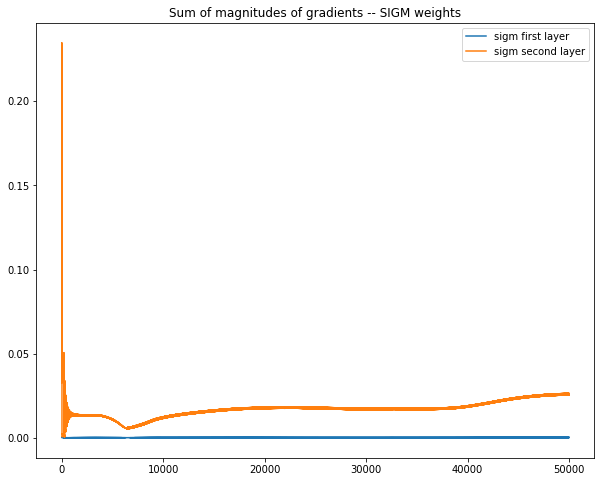

In [39]:
plt.plot(np.array(sigm_array_1))
plt.plot(np.array(sigm_array_2))
plt.title('Sum of magnitudes of gradients -- SIGM weights')
plt.legend(('sigm first layer','sigm second layer'))

In [65]:
# plot the classifiers- SIGMOID
h = 0.025
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(sigmoid(np.dot(sigmoid(np.dot(np.c_[xx.ravel(), yy.ravel()], s_W1) + s_b1), s_W2) + s_b2), s_W3) + s_b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlim(-1,1)
plt.ylim(-1,1)

MemoryError: 

In [44]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

In [56]:
np.arange(x_min, x_max, 0.05).shape

(4098,)

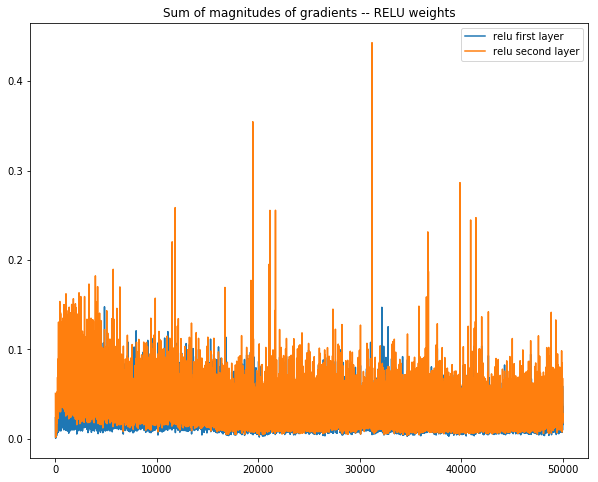

In [41]:
plt.plot(np.array(relu_array_1))
plt.plot(np.array(relu_array_2))
plt.title('Sum of magnitudes of gradients -- RELU weights')
plt.legend(('relu first layer','relu second layer'))

(-1, 1)

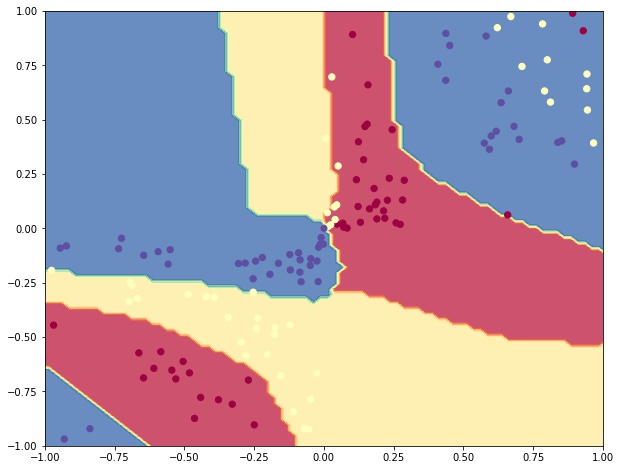

In [64]:
# plot the classifiers-- RELU
h = 0.025
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(relu(np.dot(relu(np.dot(np.c_[xx.ravel(), yy.ravel()], r_W1) + r_b1), r_W2) + r_b2), r_W3) + r_b3
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlim(-1,1)
plt.ylim(-1,1)

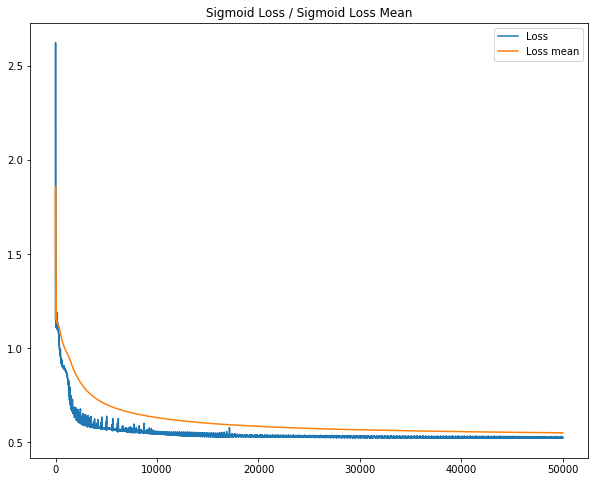

In [17]:
plt.plot(np.array(sigm_loss))
plt.plot(np.array(sigm_loss_mean))
plt.title('Sigmoid Loss / Sigmoid Loss Mean')
plt.legend(('Loss','Loss mean'))

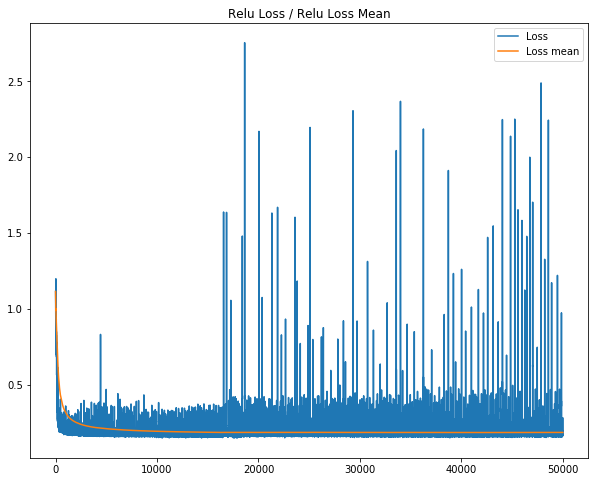

In [18]:
plt.plot(np.array(relu_loss))
plt.plot(np.array(relu_loss_mean))
plt.title('Relu Loss / Relu Loss Mean')
plt.legend(('Loss','Loss mean'))